<a href="https://colab.research.google.com/github/vvarma7262/Vaibhav/blob/master/FIFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess the data

**Load Libraries**



In [0]:
# Define the libraries and imports
# Panda
import pandas as pd
#mat plot
import matplotlib.pyplot as plt
#Sea born
import seaborn as sns
#Num py
import numpy as np
#Sk learn imports
from sklearn import tree,preprocessing
#ensembles
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import sklearn.metrics as metrics
#scores
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score,auc  
#models
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,learning_curve,GridSearchCV,validation_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
#export the model
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Load data from the path to the dataSet
def load_dataset(dataSet_path):
    data = pd.read_csv(dataSet_path)
    return data

#Imputation
def impute_data(df):
    df.dropna(inplace=True)

# Coversion weight to int
def weight_to_int(df):
    df['Weight'] = df['Weight'].str[:-3]
    df['Weight'] = df['Weight'].apply(lambda x: int(x))
    return df

# Coversion height to int
def height_convert(df_height):
        try:
            feet = int(df_height[0])
            dlm = df_height[-2]
            if dlm == "'":
                height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
            elif dlm != "'":
                height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
        except ValueError:
            height = 0
        return height

def height_to_int(df):
    df['Height'] = df['Height'].apply(height_convert)
    
#One Hot Encoding of a feature
def one_hot_encoding(df,column):
    encoder = preprocessing.LabelEncoder()
    df[column] = encoder.fit_transform(df[column].values)
        

#Drop columns that we are not interested in
def drop_columns(df):
    df.drop(df.loc[:, 'Unnamed: 0':'Name' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'Photo':'Special'],axis=1, inplace = True)
    df.drop(df.loc[:, 'International Reputation':'Real Face' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'Jersey Number':'Contract Valid Until' ],axis=1, inplace = True)
    df.drop(df.loc[:, 'LS':'RB'],axis=1, inplace = True)
    df.drop(df.loc[:, 'GKDiving':'Release Clause'],axis=1, inplace = True)

#Transform positions to 3 categories 'Striker', 'Midfielder', 'Defender'    
def transform_positions(df):
    for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
      df.loc[df.Position == i , 'Position'] = 'Striker' 
    
    for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
      df.loc[df.Position == i , 'Position'] = 'Midfielder' 
    
    for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB','GK']:
      df.loc[df.Position == i , 'Position'] = 'Defender' 

In [27]:
# Load dataset
df= load_dataset("https://raw.githubusercontent.com/amanthedorkknight/fifa18-all-player-statistics/master/2019/data.csv")
# Drop columns that we are not interested in
drop_columns(df)
# Impute the data that is null
impute_data(df)
# transform weight and height to integer values
weight_to_int(df)
height_to_int(df)
# apply the one hot encoding to the Preferred foot (L,R) => (0,1)
one_hot_encoding(df,'Preferred Foot')
# transform position to striker, midfielder, defender
transform_positions(df)
# show the 10 first rows
df.head(10)

,Age,Preferred Foot,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,31,0,Striker,170.0,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,33,1,Striker,188.0,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,26,1,Striker,175.0,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,27,1,Defender,193.0,168,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0
4,27,1,Midfielder,180.0,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0
5,27,1,Striker,173.0,163,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0
6,32,1,Midfielder,173.0,146,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0
7,31,1,Striker,183.0,190,77.0,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0
8,32,1,Defender,183.0,181,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0
9,25,1,Defender,188.0,192,13.0,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 18206
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18147 non-null  int64  
 1   Preferred Foot   18147 non-null  int64  
 2   Position         18147 non-null  object 
 3   Height           18147 non-null  float64
 4   Weight           18147 non-null  int64  
 5   Crossing         18147 non-null  float64
 6   Finishing        18147 non-null  float64
 7   HeadingAccuracy  18147 non-null  float64
 8   ShortPassing     18147 non-null  float64
 9   Volleys          18147 non-null  float64
 10  Dribbling        18147 non-null  float64
 11  Curve            18147 non-null  float64
 12  FKAccuracy       18147 non-null  float64
 13  LongPassing      18147 non-null  float64
 14  BallControl      18147 non-null  float64
 15  Acceleration     18147 non-null  float64
 16  SprintSpeed      18147 non-null  float64
 17  Agility     

# Visualization



**Players counts by position**

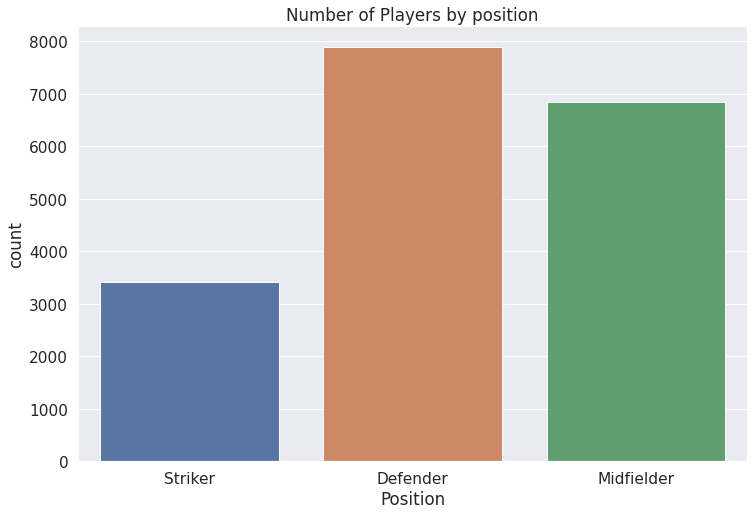

In [29]:
# Count number of players in each position using countplot
plt.figure(figsize=(12, 8))
plt.title("Number of Players by position")
fig = sns.countplot(x = 'Position', data =df)

In [0]:
# Define categorical skills base on the rating
def categorize_skill(df,column):
    bins = (10,30,50,70,100)
    group_names = ['Low','Moderate','High','VeryHigh']
    categories = pd.cut(df[column],bins,labels=group_names)
    new_column = column+'_cat'
    df[new_column]=categories
categorize_skill(df,"Finishing")
categorize_skill(df,"Strength")
categorize_skill(df,"FKAccuracy")



**Short Passing by finishing according to the positions**


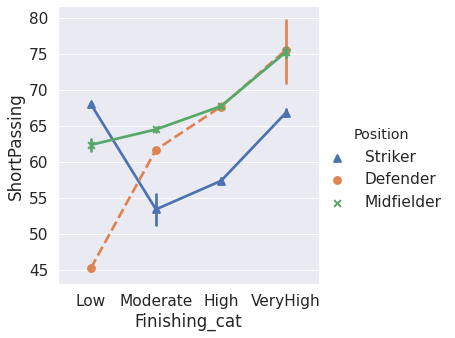

In [31]:
# Crate Category plot from seaborn on Finishing & ShortPassing By position
sns.catplot(x="Finishing_cat", y="ShortPassing", hue="Position",
            markers=["^", "o","x"], linestyles=["-", "--","-"],
            kind="point", data=df);

**Interceptions by Strength according to the positions**

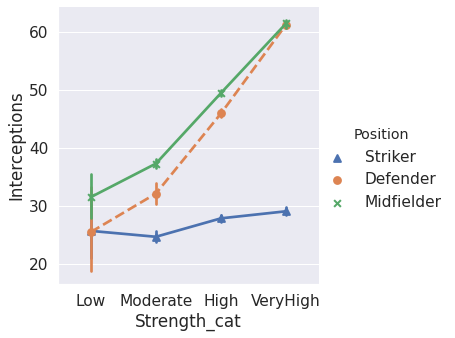

In [32]:
# Crate Category plot from seaborn on  Strength & Interception By position
sns.catplot(x="Strength_cat", y="Interceptions", hue="Position",
            markers=["^", "o","x"], linestyles=["-", "--","-"],
            kind="point", data=df);

**Interceptions by Strength according to the positions**

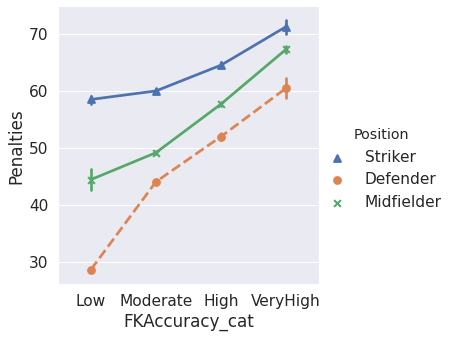

In [33]:
# Crate Category plot from seaborn on FKAccuracy & Penalties By position
sns.catplot(x="FKAccuracy_cat", y="Penalties", hue="Position",
            markers=["^", "o","x"], linestyles=["-", "--","-"],
            kind="point", data=df);

**Physical appearences by position**



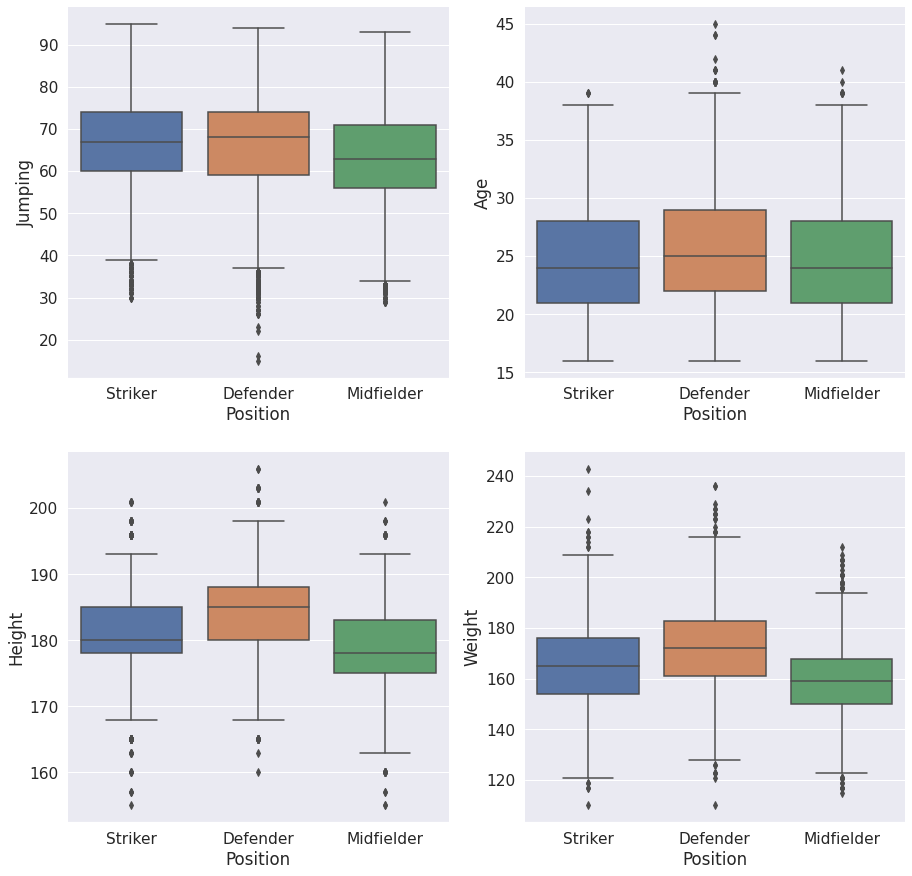

In [34]:
# Box plot skills by position
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
sns.despine(left=True)
sns.boxplot('Position', 'Jumping', data = df, ax=axes[0, 0])
sns.boxplot('Position', 'Age', data = df, ax=axes[0, 1])
sns.boxplot('Position', 'Height', data = df, ax=axes[1, 0])
sns.boxplot('Position', 'Weight', data = df, ax=axes[1, 1])

**Reaction by age**

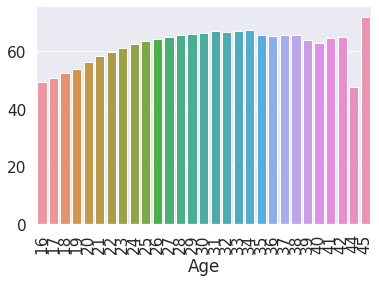

In [35]:
# Bar plot Reaction by Age
mean_value_per_age = df.groupby('Age')['Reactions'].mean()
p = sns.barplot(x = mean_value_per_age.index, y = mean_value_per_age.values)
p = plt.xticks(rotation=90)

**Scatter plot skills and positions**

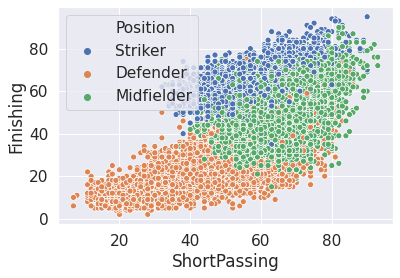

In [36]:
#Scatter plot Finishing by shortPassing classified by position
ax = sns.scatterplot(x="ShortPassing", y="Finishing", hue="Position",data=df)

**Features correlation**



In [0]:
# Drop some of unuseful coloumns
drop_elements = ['Position', 'Finishing_cat', 'Strength_cat', 'FKAccuracy_cat']
train=df.drop(drop_elements, axis = 1)

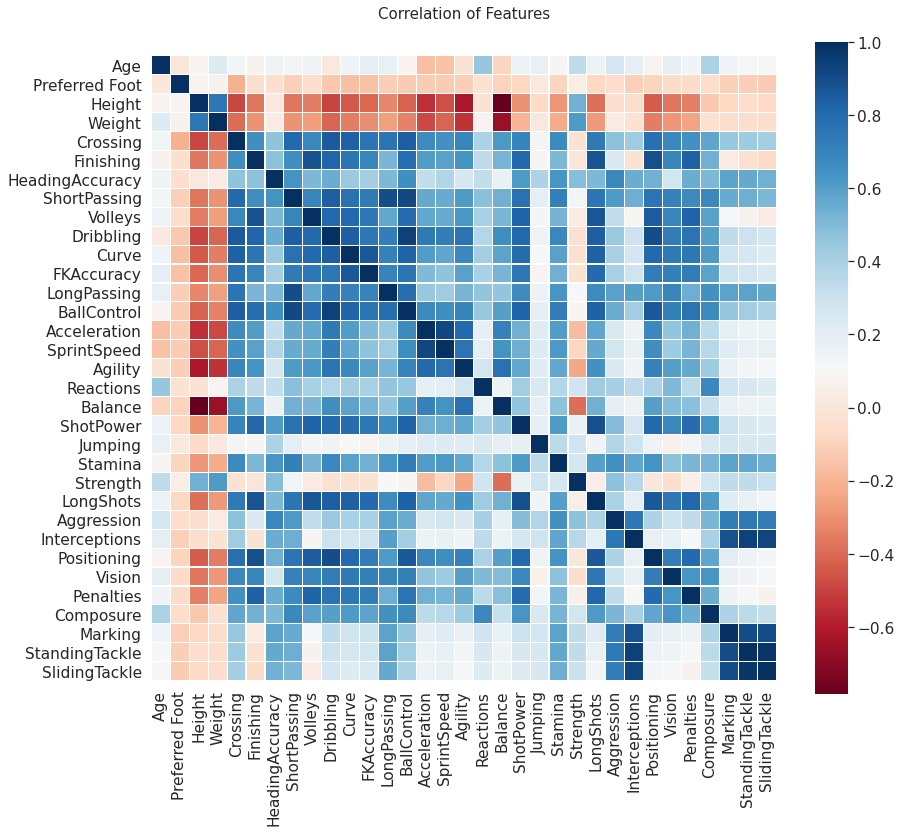

In [38]:
# Create the heat map of features correlation
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

In [0]:
# Divide the data to train and test

# Drop the elements that has been created for 
drop_elements = ['Finishing_cat', 'Strength_cat', 'FKAccuracy_cat']
df=df.drop(drop_elements, axis = 1)

# Create the unique values for the positions encoded as Defender:0, Midfielder:1, Striker:2
positions = df["Position"].unique()
encoder = preprocessing.LabelEncoder()
df['Position'] = encoder.fit_transform(df['Position'])

#The Y feature is the position
y = df["Position"]

#The other features are all but the position
df.drop(columns=["Position"],inplace=True)

#Split the data
X_train_dev, X_test, y_train_dev, y_test = train_test_split(df, y, 
                                                    test_size=0.20, 
                                                    random_state=42 )




**Plot Confusion Matrix**



In [0]:
# Plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=1.4)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# 5.1. Logistic regression

We apply our first model Logistic regression with a cross validation of 5 folds.

Figure(720x504)
 Accuracy:  0.8801652892561983
 F1 score:  0.8800773527259692


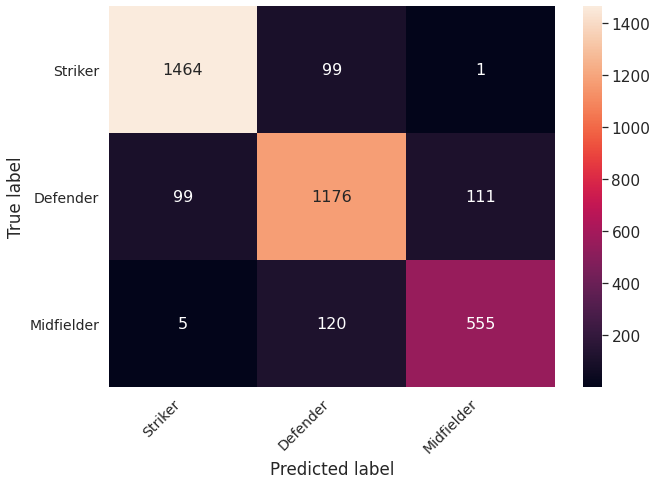

In [44]:
LR = LogisticRegressionCV(cv=5,random_state=20, solver='lbfgs',
                             multi_class='multinomial')
train_and_score(LR,X_train_dev,y_train_dev,X_test,y_test)

In [0]:
plot_learning_curve(LR, "Logistic Regression Curve", X_train_dev, y_train_dev)

# 5.2. K-nearest Neighbours

Then, we apply the KNN model with gread serach that apply to the K (number of neighbors) in a range from 1 to 25 with a cross validation of 5.

In [0]:
#create new a knn model
knn_model = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
KNN = GridSearchCV(knn_model, param_grid, cv=5)

train_and_score(KNN,X_train_dev,y_train_dev,X_test,y_test)

In [0]:
plot_learning_curve(KNN, "KNN Regression Curve", X_train_dev, y_train_dev)

We want to draw the model complexity curve and see how far the model is learning based on the n_neighbours range.

In [0]:
plot_validation_curve(KNeighborsClassifier(), X_train_dev, y_train_dev, param_name='n_neighbors', param_range=range(2,25))

# 5.3. Decision Tree

First all, let's define a function that calculate the best minimum impurity a parameter to pass to the decision tree.

In [0]:
def min_impurity(X,y):
    tr_acc = []
    mln_set = range(75,90)                                 

    for minImp in mln_set:
        clf = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=minImp/100000)
        scores = cross_val_score(clf, X, y, cv=10)
        tr_acc.append(scores.mean())

    best_mln = mln_set[np.argmax(tr_acc)]
    return best_mln

best_min= min_impurity(X_train_dev,y_train_dev)

Now, let's apply the Decision Tree model with the best minimum impurity.

In [0]:
DT = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=best_min/100000)
train_and_score(DT,X_train_dev,y_train_dev,X_test,y_test)

In [0]:
plot_learning_curve(DT, "Decision Tree Learning Curve", X_train_dev, y_train_dev)